In [105]:
# --- CELL 1: Imports & config ---
import os, random, math, itertools, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

In [107]:
# Pour que les résultats soient reproductibles (même splits, mêmes poids initiaux)
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

In [103]:
# Dossiers de travail : dataset (images Tifinagh) et sauvegarde des modèles
DATA_DIR = "AMHCD_64"   
SAVE_DIR = "artifacts_lenet5"
os.makedirs(SAVE_DIR, exist_ok=True)

In [63]:
# Hyperparamètres classiques
IMG_SIZE = 32         # LeNet-5 travaille avec des images 32x32
BATCH_SIZE = 128
EPOCHS = 25
LR = 1e-3
OPTIMIZER = "adam"    # choix entre SGD et Adam
WEIGHT_DECAY = 0.0    # régularisation L2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [65]:
# --- CELL 2: Dataset & transforms ---
# Prétraitement : resize, normalisation, petites augmentations pour le train
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [69]:
# Chargement des images (structure: dossier par classe)
full_ds = datasets.ImageFolder(root=DATA_DIR, transform=train_tf)
num_classes = len(full_ds.classes)
assert num_classes >= 2, "Il faut au moins deux classes"

In [71]:
# Découpage du dataset en 80% train, 10% val, 10% test
n_total = len(full_ds)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)
n_test = n_total - n_train - n_val
train_ds, val_ds, test_ds = random_split(full_ds, [n_train, n_val, n_test], generator=torch.Generator().manual_seed(SEED))

In [73]:
# Pour la validation et le test, on enlève les augmentations (seulement resize+normalize)
val_ds.dataset.transform = test_tf
test_ds.dataset.transform = test_tf

In [75]:
# DataLoaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Classes:", full_ds.classes, "\n#train:", n_train, "#val:", n_val, "#test:", n_test, "num_classes:", num_classes)

Classes: ['ya', 'yab', 'yach', 'yad', 'yadd', 'yae', 'yaf', 'yag', 'yagh', 'yagw', 'yah', 'yahh', 'yaj', 'yak', 'yakw', 'yal', 'yam', 'yan', 'yaq', 'yar', 'yarr', 'yas', 'yass', 'yat', 'yatt', 'yaw', 'yax', 'yay', 'yaz', 'yazz', 'yey', 'yi', 'yu'] 
#train: 20592 #val: 2574 #test: 2574 num_classes: 33


In [77]:
# --- CELL 3: Modèle LeNet-5 ---
class LeNet5(nn.Module):
    """
    Version adaptée de LeNet-5 pour images RGB.
    Architecture : Conv(6) -> AvgPool -> Conv(16) -> AvgPool -> FC(120) -> FC(84) -> FC(num_classes)
    """
    def __init__(self, num_classes=33, in_channels=3):
        super().__init__()
        self.c1 = nn.Conv2d(in_channels, 6, kernel_size=5, stride=1)     # sortie 28x28
        self.s2 = nn.AvgPool2d(kernel_size=2, stride=2)                   # sortie 14x14
        self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)               # sortie 10x10
        self.s4 = nn.AvgPool2d(kernel_size=2, stride=2)                   # sortie 5x5
        self.c5 = nn.Linear(16*5*5, 120)                                  # couche fully-connected
        self.f6 = nn.Linear(120, 84)
        self.out = nn.Linear(84, num_classes)

    def forward(self, x):
        # Dans l’article original, l’activation est Tanh (on pourrait comparer avec ReLU)
        x = F.tanh(self.c1(x))
        x = self.s2(x)
        x = F.tanh(self.c3(x))
        x = self.s4(x)
        x = x.view(x.size(0), -1)
        x = F.tanh(self.c5(x))
        x = F.tanh(self.f6(x))
        return self.out(x)

model = LeNet5(num_classes=num_classes, in_channels=3).to(DEVICE)
print(model)

LeNet5(
  (c1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (s2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (c5): Linear(in_features=400, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (out): Linear(in_features=84, out_features=33, bias=True)
)


In [79]:
# --- CELL 4: Optimiseur, loss, scheduler ---
if OPTIMIZER.lower() == "sgd":
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=WEIGHT_DECAY, nesterov=True)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

def accuracy_from_logits(logits, y):
    preds = torch.argmax(logits, dim=1)
    return (preds == y).float().mean().item()

In [81]:
# --- CELL 5: Boucle d’entraînement ---
def run_epoch(loader, train=True):
    model.train(train)
    epoch_loss, epoch_acc, n = 0.0, 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE, non_blocking=True), yb.to(DEVICE, non_blocking=True)
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
        if train:
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
        bsz = yb.size(0)
        acc = accuracy_from_logits(logits, yb)
        epoch_loss += loss.item()*bsz
        epoch_acc  += acc*bsz
        n += bsz
    return epoch_loss/n, epoch_acc/n

best_val, best_path = float("inf"), os.path.join(SAVE_DIR, "best_lenet5.pth")
history = {"train_loss":[], "val_loss":[], "train_acc":[], "val_acc":[]}

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    val_loss, val_acc = run_epoch(val_loader, train=False)
    scheduler.step(val_loss)
    history["train_loss"].append(tr_loss); history["val_loss"].append(val_loss)
    history["train_acc"].append(tr_acc);   history["val_acc"].append(val_acc)
    if val_loss < best_val:
        best_val = val_loss
        torch.save({"model": model.state_dict(), "classes": full_ds.classes}, best_path)
    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train_loss={tr_loss:.4f} val_loss={val_loss:.4f} "
          f"train_acc={tr_acc:.3f} val_acc={val_acc:.3f} "
          f"({time.time()-t0:.1f}s)")

print("Meilleur modèle sauvegardé dans:", best_path)

C:\Users\PP\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


[01/25] train_loss=2.0452 val_loss=0.8821 train_acc=0.507 val_acc=0.807 (256.5s)
[02/25] train_loss=0.6358 val_loss=0.5116 train_acc=0.851 val_acc=0.883 (67.3s)
[03/25] train_loss=0.3863 val_loss=0.3603 train_acc=0.906 val_acc=0.911 (64.7s)
[04/25] train_loss=0.2852 val_loss=0.2856 train_acc=0.928 val_acc=0.929 (61.8s)
[05/25] train_loss=0.2131 val_loss=0.2338 train_acc=0.945 val_acc=0.944 (64.6s)
[06/25] train_loss=0.1752 val_loss=0.2193 train_acc=0.956 val_acc=0.943 (61.0s)
[07/25] train_loss=0.1354 val_loss=0.1826 train_acc=0.967 val_acc=0.954 (63.3s)
[08/25] train_loss=0.1109 val_loss=0.1675 train_acc=0.973 val_acc=0.956 (63.5s)
[09/25] train_loss=0.0910 val_loss=0.1602 train_acc=0.978 val_acc=0.960 (62.4s)
[10/25] train_loss=0.0802 val_loss=0.1459 train_acc=0.981 val_acc=0.962 (62.1s)
[11/25] train_loss=0.0631 val_loss=0.1422 train_acc=0.986 val_acc=0.963 (63.5s)
[12/25] train_loss=0.0536 val_loss=0.1391 train_acc=0.989 val_acc=0.962 (62.1s)
[13/25] train_loss=0.0461 val_loss=0.12

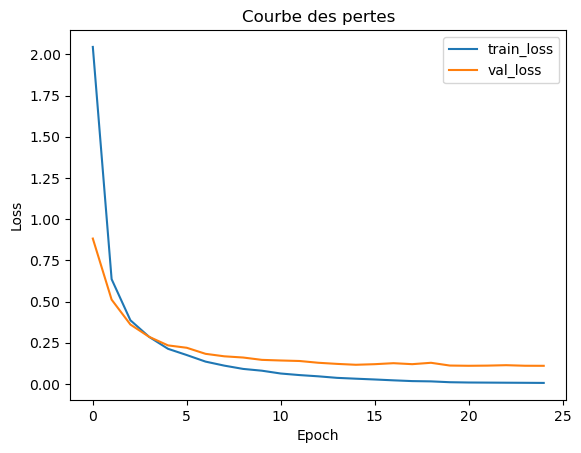

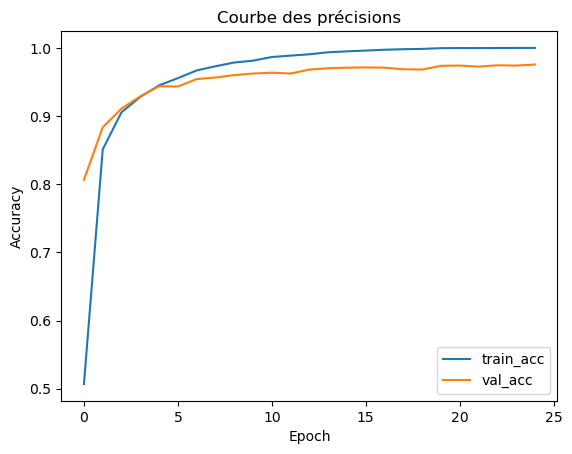

In [85]:
# --- CELL 6: Courbes d’évolution (loss/accuracy) ---
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Courbe des pertes"); plt.legend(); plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Courbe des précisions"); plt.legend(); plt.show()

In [87]:
# --- CELL 7: Évaluation finale sur le test ---
ckpt = torch.load(best_path, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

all_preds, all_targets = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_targets.append(yb.numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

print("Accuracy test:", (all_preds==all_targets).mean())
print(classification_report(all_targets, all_preds, target_names=full_ds.classes, digits=4))

Accuracy test: 0.973970473970474
              precision    recall  f1-score   support

          ya     1.0000    1.0000    1.0000        82
         yab     0.9762    0.9880    0.9820        83
        yach     1.0000    0.9610    0.9801        77
         yad     0.9733    1.0000    0.9865        73
        yadd     0.9759    1.0000    0.9878        81
         yae     0.9859    1.0000    0.9929        70
         yaf     0.9753    0.9634    0.9693        82
         yag     0.9714    0.9855    0.9784        69
        yagh     1.0000    0.9853    0.9926        68
        yagw     0.9643    1.0000    0.9818        81
         yah     1.0000    0.9756    0.9877        82
        yahh     0.9870    0.9744    0.9806        78
         yaj     1.0000    0.9639    0.9816        83
         yak     0.9880    0.9647    0.9762        85
        yakw     0.9870    0.9620    0.9744        79
         yal     0.9524    0.9836    0.9677        61
         yam     0.9744    0.9870    0.9806     

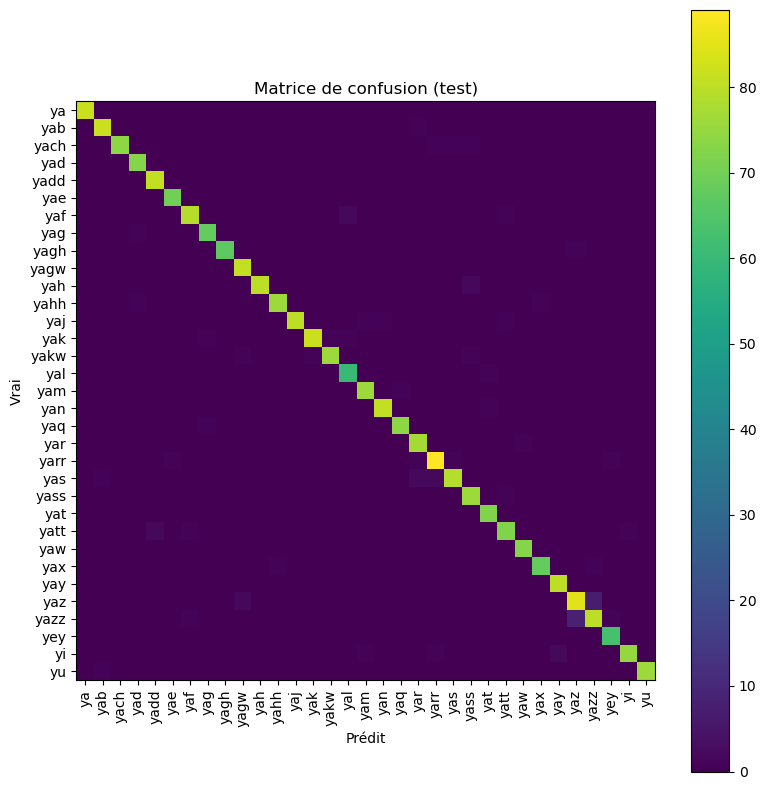

In [89]:
# --- CELL 8: Matrice de confusion ---
cm = confusion_matrix(all_targets, all_preds, labels=list(range(num_classes)))
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation="nearest")
plt.title("Matrice de confusion (test)")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, full_ds.classes, rotation=90)
plt.yticks(tick_marks, full_ds.classes)
plt.tight_layout()
plt.xlabel("Prédit"); plt.ylabel("Vrai")
plt.show()

In [91]:
# --- CELL 9: Visualisation des feature maps ---
feature_maps = {}
def get_hook(name):
    def hook(m, inp, out):
        feature_maps[name] = out.detach().cpu()
    return hook

h1 = model.c1.register_forward_hook(get_hook("c1"))
h3 = model.c3.register_forward_hook(get_hook("c3"))

xb, yb = next(iter(test_loader))
xb = xb.to(DEVICE)
with torch.no_grad():
    _ = model(xb[:1])  # une seule image

C:\Users\PP\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


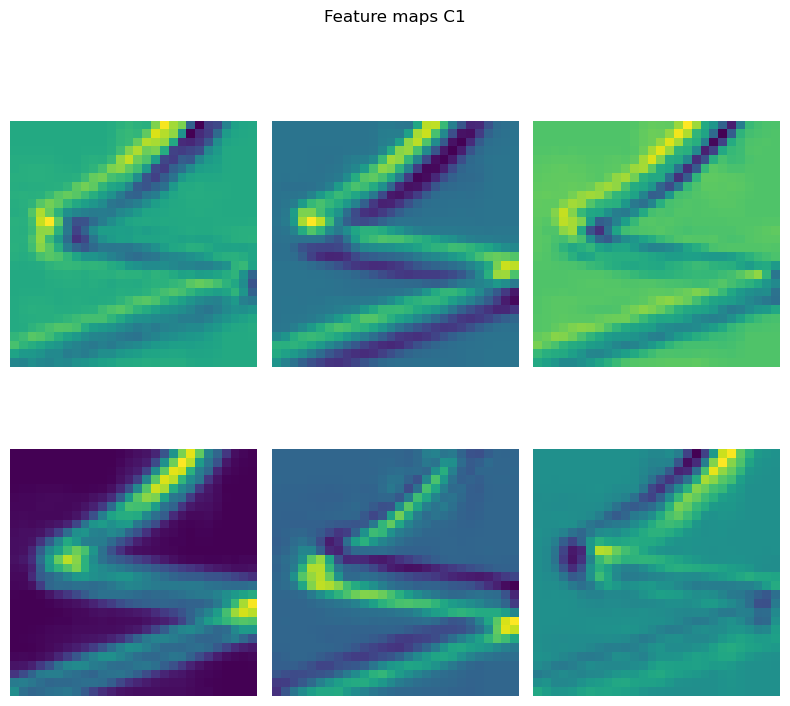

In [93]:
# Feature maps de la première couche
fm1 = feature_maps["c1"][0]
n_show = fm1.size(0)
cols = 3
rows = math.ceil(n_show/cols)
plt.figure(figsize=(8, 8))
for i in range(n_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(fm1[i].numpy())
    plt.axis("off")
plt.suptitle("Feature maps C1")
plt.tight_layout(); plt.show()

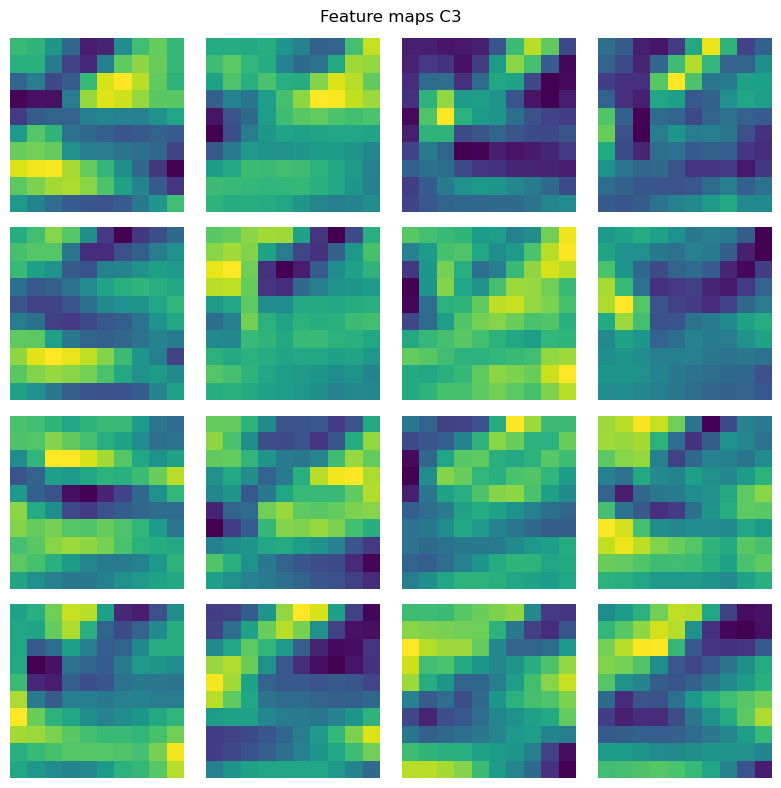

In [95]:
# Feature maps de la troisième couche
fm3 = feature_maps["c3"][0]
n_show = fm3.size(0)
cols = 4
rows = math.ceil(n_show/cols)
plt.figure(figsize=(8, 8))
for i in range(n_show):
    plt.subplot(rows, cols, i+1)
    plt.imshow(fm3[i].numpy())
    plt.axis("off")
plt.suptitle("Feature maps C3")
plt.tight_layout(); plt.show()

h1.remove(); h3.remove()

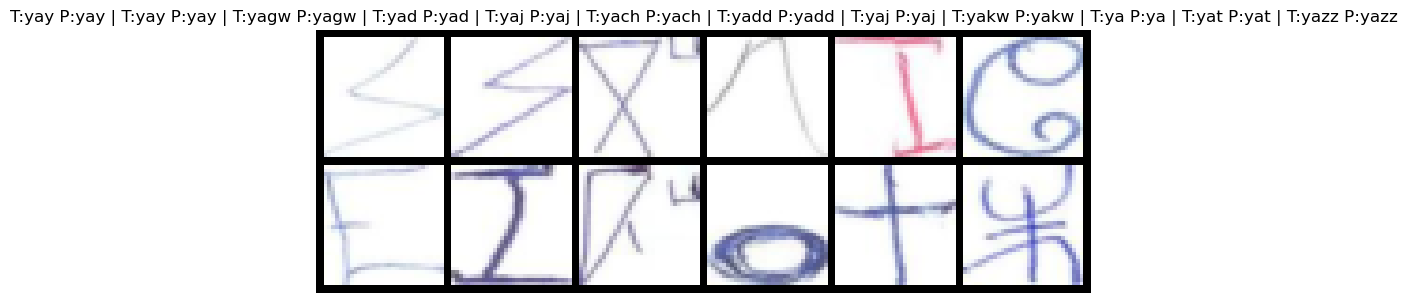

In [97]:
# --- CELL 10: Visualisation des exemples prédits ---
def show_examples(loader, n=12):
    imgs, gts, prs = [], [], []
    with torch.no_grad():
        for xb, yb in loader:
            logits = model(xb.to(DEVICE))
            pred = torch.argmax(logits, dim=1).cpu()
            for i in range(xb.size(0)):
                imgs.append(xb[i])
                gts.append(yb[i].item())
                prs.append(pred[i].item())
                if len(imgs) >= n: break
            if len(imgs) >= n: break
    grid = make_grid(torch.stack([ (img*torch.tensor(std)[:,None,None] + torch.tensor(mean)[:,None,None]) for img in imgs ], dim=0), nrow=6)
    plt.figure(figsize=(10,4))
    plt.imshow(np.transpose(grid.numpy(), (1,2,0)))
    plt.axis("off")
    title = " | ".join([f"T:{full_ds.classes[g]} P:{full_ds.classes[p]}" for g,p in zip(gts, prs)])
    plt.title(title[:200] + ("..." if len(title)>200 else ""))
    plt.show()

show_examples(test_loader, n=12)